# Modifying the environment

The floor is now covered in ice! 
When an agent makes a movement, it might slip and end up in another cell close to it.
The probability to arrive in the intended cell is 0.6, and the probability to end up in one of the 4 adjacent cells is 0.1.

The step function should incorportate these slippery dynamics.

When the agent slips, rewards accumulate! You could bang your head on the wall twice...


In [20]:
from dungeon.dungeon import Dungeon
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt

#using the same structure used in dynamic programming example to map index to action
Action = namedtuple('Action', 'name index delta_i delta_j')
    
up = Action('up', 0, -1, 0)    
down = Action('down', 1, 1, 0)    
left = Action('left', 2, 0, -1)    
right = Action('right', 3, 0, 1)    

index_to_actions = {}
for action in [up, down, left, right]:
    index_to_actions[action.index] = action

In [21]:


class IceDungeon(Dungeon):
    
    def __init__(self, N):
        
        super().__init__(N)
        
        # assign a random index for each coordinate of the grid        
        index_states = np.arange(0, N*N)
        np.random.shuffle(index_states)
        self.coord_to_index_state = index_states.reshape(N,N)    
        
    def step(self, action):
        
        obs, reward, done = super().step(action)
        state = self.coord_to_index_state[self.position_agent[0], self.position_agent[1]]

        if done:
            return state, reward, done

        else:
            # select whether you move again, or stay in your current position
            # 0.1 probability of slipping in each direction and 0.6 of not slipping!
            proba_of_slipping = [0.1, 0.1, 0.1, 0.1, 0.6]
            
            index_action = np.argmax(np.random.multinomial(1, proba_of_slipping ))

            # If the agent stays in place:
            if index_action == 4: #index of 0.6
                return state, reward, done #act as usual 
            
            # Else it moves to another cell
            else: 
                obs, reward_slip, done = super().step(index_to_actions[index_action].name) #take name of action from named tuple
                state = self.coord_to_index_state[self.position_agent[0], self.position_agent[1]] #return new state
       
                # Don't penalize for second step, and don't increment timesteps.
                reward_slip += 1
                self.time_elapsed -= 1 #take 1 away from time_elapsed
            
                return state, reward + reward_slip, done
            
    def reset(self):
        
        super().reset() #inherit reset function 
        
        state = self.coord_to_index_state[self.position_agent[0], self.position_agent[1]] #return new state
        
        return state
        

# Monte-carlo learning

Use a simple random policy function to evaluate the state values. 

Create a random policy function that just picks random actions

Then, implement a MC learning class that allows to learn the values based on full rollouts of the policy in the environment.

Finally, generate rollouts of the policy in an environment, and update the values using MC-learning.

In [31]:
import random

def random_policy(state):
    
    return random.choice(['up', 'down', 'left', 'right']) #choose randomly from the different directions
    
class MC_Learning():
    
    def __init__(self, envir, gamma):
        
        self.size_environment = envir.size
        self.gamma = gamma #discount factor 
        self.coord_to_index_state = envir.coord_to_index_state
        
        self.values = np.zeros( (self.size_environment*self.size_environment) )
        
        self.counter = np.zeros( (self.size_environment*self.size_environment) )
    
    def update_values(self, rollout):
        
        # Calculate returns by going backwards
        g = 0 #g = returns
    
        rollout_with_returns = [] #rollout of policy in environment 
        for s, r in rollout[::-1]:
            
            g = g*self.gamma + r
            
            rollout_with_returns.append( (s,g))
        
        rollout_with_returns = rollout_with_returns[::-1] 
            
        # Update the values
        for s, g in rollout_with_returns:
            
            self.counter[s] += 1
            self.values[s] += 1/self.counter[s]*( g - self.values[s] )
            
    def display_values(self):
        
        value_matrix = np.zeros( (self.size_environment, self.size_environment) )
    
    
        for i in range(self.size_environment):
            for j in range(self.size_environment):

                state = self.coord_to_index_state[i, j]
                
                value_matrix[i,j] = self.values[state]
                
        return value_matrix
        

In [32]:

def perform_rollout(envir): #produce rollout
    s = envir.reset()
    done = False
    
    rollout = []
    while not done:
        action = random_policy(s) 
        s_next, r, done = envir.step(action)
        
        rollout.append((s, r)) #s = state r = reward 
        s = s_next
    
    return rollout

In [33]:
dungeon = IceDungeon(20)
mc = MC_Learning(dungeon, 0.99)

dungeon.reset()
dungeon.display()

X X X X X X X X X X X X X X X X X X X X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . . X . . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . L X . . . . . . . . X 
X . . . . . . . . . . . . . . L . . . X 
X . . . . . . . . . . . . . . . L . . X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X L . . . . . . . . . . . L . . . . . X 
X . . . L X . . . . . . . . . . . . L X 
X . . . . . . . . . . . E . . . . . . X 
X . . . . . . . . . . . . . . . . . L X 
X . . . . . . . . . . . . . . . . . . X 
X . . . X . . . . . X . . . . L . . . X 
X . . . . . . . . . . . . . X . . . . X 
X . . . . . . . . . . . . . . X . A . X 
X X . . . . . . . X . . . . . . . L . X 
X . . . . . . . . . . . . . . . . . . X 
X X X X X X X X X X X X X X X X X X X X 



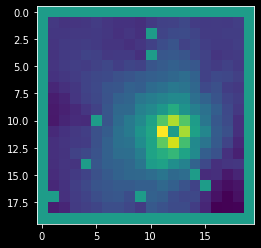

In [52]:
rol = perform_rollout(dungeon)
mc.update_values(rol)

vals = mc.display_values()
plt.imshow( (vals - vals.min())/(vals.max() - vals.min()) )
plt.show()

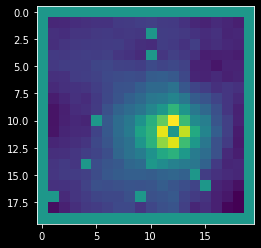

In [53]:
mc = MC_Learning(dungeon, 0.99)
for i in range(1000):
    rol = perform_rollout(dungeon)
    mc.update_values(rol)

vals = mc.display_values()
plt.imshow( (vals - vals.min())/(vals.max() - vals.min()) )
plt.show()

# TD-learning

Compare the values obtained by MC learning with values obtained with TD learning.

Create a class that allows to update values every time a new state transition occurs.


In [47]:
class TD_Learning():   
    def __init__(self, envir, alpha, gamma):
        
        self.size_environment = envir.size
        self.alpha = alpha
        self.gamma = gamma
        self.coord_to_index_state = envir.coord_to_index_state
        
        self.values = np.zeros( (self.size_environment*self.size_environment) )
    
    def update_values(self, s_current, reward_next, s_next):
        
        self.values[s_current] = self.values[s_current] + self.alpha * (reward_next + self.gamma*self.values[s_next] - self.values[s_current] ) #Implementing equation for TD Learning 
        
    def display_values(self):
        
        value_matrix = np.zeros( (self.size_environment, self.size_environment) )
    
    
        for i in range(self.size_environment):
            for j in range(self.size_environment):

                state = self.coord_to_index_state[i, j]
                
                value_matrix[i,j] = self.values[state]
                
        return value_matrix
        

In [48]:
def td_learning_episode(td, envir):
    s = envir.reset()
    done = False
    
    while not done:
        action = random_policy(s) 
        s_next, r, done = envir.step(action)
        
        td.update_values(s, r, s_next)
        
        s = s_next
    


In [49]:
td = TD_Learning(dungeon, 0.1, 0.99)

dungeon.reset()
dungeon.display()

X X X X X X X X X X X X X X X X X X X X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . . X . . . . . . . . X 
X . . . . . . . . . . . . . A . . . . X 
X . . . . . . . . L X . . . . . . . . X 
X . . . . . . . . . . . . . . L . . . X 
X . . . . . . . . . . . . . . . L . . X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X L . . . . . . . . . . . L . . . . . X 
X . . . L X . . . . . . . . . . . . L X 
X . . . . . . . . . . . E . . . . . . X 
X . . . . . . . . . . . . . . . . . L X 
X . . . . . . . . . . . . . . . . . . X 
X . . . X . . . . . X . . . . L . . . X 
X . . . . . . . . . . . . . X . . . . X 
X . . . . . . . . . . . . . . X . . . X 
X X . . . . . . . X . . . . . . . L . X 
X . . . . . . . . . . . . . . . . . . X 
X X X X X X X X X X X X X X X X X X X X 



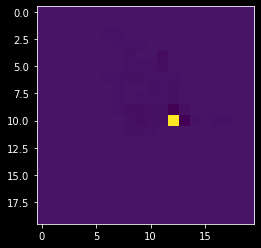

In [50]:
td_learning_episode(td, dungeon)

vals = td.display_values()
plt.imshow( (vals - vals.min())/(vals.max() - vals.min()) )
plt.show()

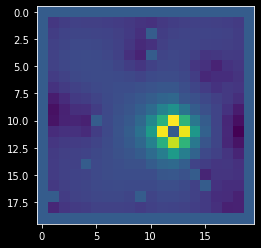

In [51]:
td = TD_Learning(dungeon, 0.01, 0.99)

for i in range(1000):
    td_learning_episode(td, dungeon)

vals = td.display_values()
plt.imshow( (vals - vals.min())/(vals.max() - vals.min()) )
plt.show()